Accuracy: 1.00
Model saved as iris_model.pkl
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1332 - val_loss: 0.0275
Epoch 2/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_loss: 0.0137
Epoch 3/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - val_loss: 0.0077
Epoch 4/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 5/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0027 - val_loss: 0.0035
Epoch 6/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 7/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 8/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 9/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 10/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

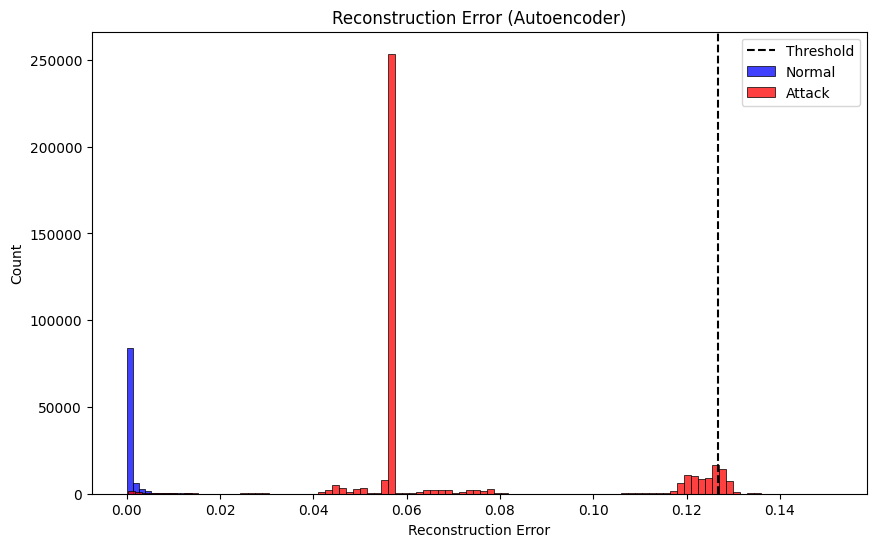

Isolation Forest Results:
[[ 29700 367043]
 [ 19701  77577]]
              precision    recall  f1-score   support

      Attack       0.60      0.07      0.13    396743
      Normal       0.17      0.80      0.29     97278

    accuracy                           0.22    494021
   macro avg       0.39      0.44      0.21    494021
weighted avg       0.52      0.22      0.16    494021



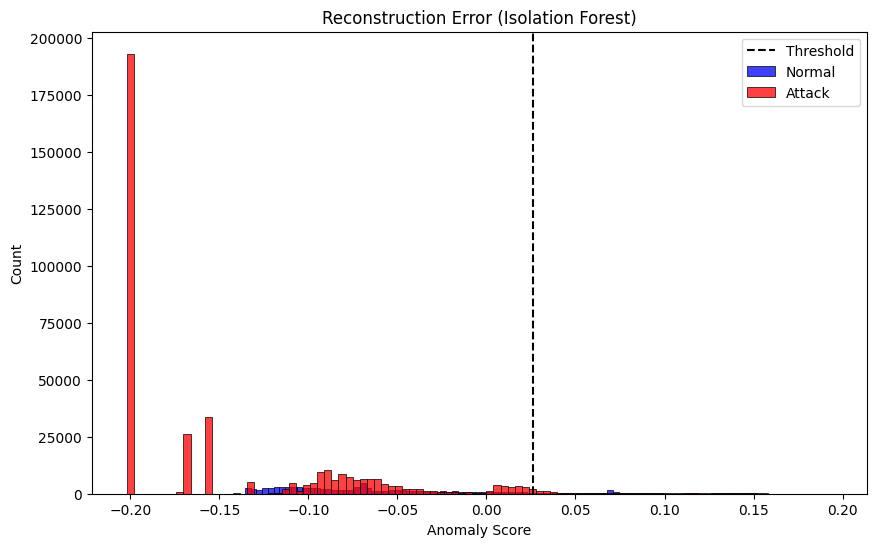

In [7]:
# Step 1: Install required libraries
!pip install scikit-learn joblib --quiet

# Step 2: Train and save the model (Iris classification example)

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib

# Step 2.1: Load dataset
iris = load_iris()
X = iris.data
y = iris.target

# Step 2.2: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2.3: Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 2.4: Evaluate
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Step 2.5: Save model
joblib.dump(model, 'iris_model.pkl')
print("Model saved as iris_model.pkl")

# Step 4: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 5: Load Dataset
import pandas as pd
import numpy as np

# Step 5.1: Set the correct path to your dataset
file_path = '/content/drive/MyDrive/kddcup.data_10_percent_corrected'

# Step 5.2: Define column names from KDD documentation
columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent",
           "hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root",
           "num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login",
           "is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate",
           "same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
           "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
           "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
           "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

df = pd.read_csv(file_path, names=columns)
df['label'] = df['label'].apply(lambda x: 'normal' if x == 'normal.' else 'attack')

# Step 6: Preprocess Data
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Step 6.1: Encode categorical columns
cat_cols = ['protocol_type', 'service', 'flag']
df[cat_cols] = df[cat_cols].apply(LabelEncoder().fit_transform)

# Step 6.2: Drop constant column
df.drop(['num_outbound_cmds'], axis=1, inplace=True)

# Step 6.3: Split features and labels
X = df.drop('label', axis=1)
y = df['label']

# Step 6.4: Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 7: Autoencoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Step 7.1: Use only normal data for training
X_train = X_scaled[y == 'normal']
X_test = X_scaled
y_binary = y.apply(lambda x: 0 if x == 'normal' else 1).values  # 1 = anomaly

# Step 7.2: Build Autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 20

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation="relu")(input_layer)
decoded = Dense(input_dim, activation="sigmoid")(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Step 7.3: Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=256, shuffle=True, validation_split=0.2, verbose=1)

# Step 8: Evaluate Autoencoder
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.square(X_test - reconstructions), axis=1)

# Step 8.1: Set threshold at 95th percentile of reconstruction error
threshold = np.percentile(mse, 95)
y_pred_ae = (mse > threshold).astype(int)  # 1 = anomaly

print("Autoencoder Results:")
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_binary, y_pred_ae))
print(classification_report(y_binary, y_pred_ae, target_names=["Normal", "Attack"]))

# Step 8.2: Plot Autoencoder Reconstruction Error
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(mse[y_binary == 0], label='Normal', color='blue', bins=100)
sns.histplot(mse[y_binary == 1], label='Attack', color='red', bins=100)
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.title("Reconstruction Error (Autoencoder)")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.legend()
plt.show()

# Step 9: Isolation Forest
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report

# Step 9.1: Convert labels to binary for evaluation
y_true_if = np.where(y == 'normal', 1, -1)

# Step 9.2: Fit Isolation Forest
iso = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
y_pred_if = iso.fit_predict(X_scaled)

# Step 9.3: Evaluation
print("Isolation Forest Results:")
print(confusion_matrix(y_true_if, y_pred_if))
print(classification_report(y_true_if, y_pred_if, target_names=["Attack", "Normal"]))

# Step 9.4: Plot Isolation Forest Reconstruction Error
# Get the decision function scores (anomaly scores)
scores_if = iso.decision_function(X_scaled)

# Calculate reconstruction error as the negative of the anomaly score (lower score = more anomalous)
mse_if = -scores_if

# Step 9.5: Set threshold at 95th percentile of reconstruction error for Isolation Forest
threshold_if = np.percentile(mse_if, 95)

# Plot the reconstruction error distribution for Isolation Forest
plt.figure(figsize=(10,6))
sns.histplot(mse_if[y_true_if == 1], label='Normal', color='blue', bins=100)
sns.histplot(mse_if[y_true_if == -1], label='Attack', color='red', bins=100)
plt.axvline(threshold_if, color='black', linestyle='--', label='Threshold')
plt.title("Reconstruction Error (Isolation Forest)")
plt.xlabel("Anomaly Score")
plt.ylabel("Count")
plt.legend()
plt.show()
